## Imports

In [1]:
import requests
import imageio
import matplotlib.pyplot as plt
import random as rnd
import json
import numpy as np
import gym
import ray
from ray import tune
import pickle
import pandas as pd
import ray.rllib.agents.ppo as ppo
import time
import subprocess

/Users/nicolaskuhaupt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
key = "******" # for TomTom API
number_destinations = 6 # for traveling salesman

# Plot of Berlin as overview

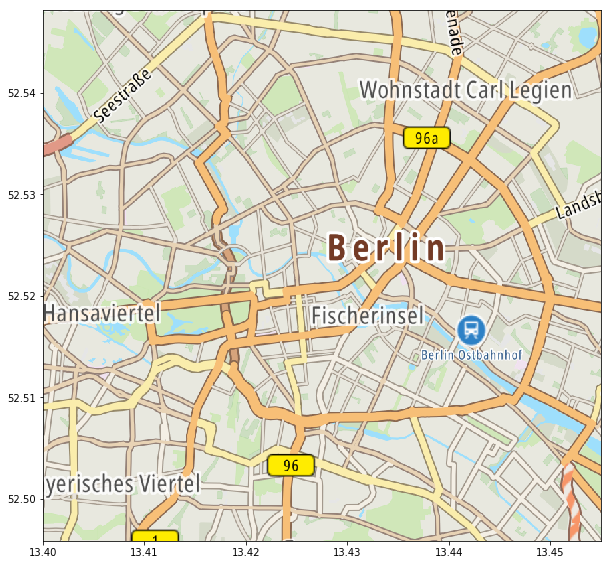

In [3]:
def plot_berlin():
    map_query = f"https://api.tomtom.com/map/1/staticimage?layer=basic&style=main&format=png&bbox=13.3231158%2C52.48%2C13.46727%2C52.5581317&view=Unified&key={key}"
    res = requests.get(map_query)
    im = imageio.imread(res.content)
    plt.figure(figsize=(10,10))
    plt.imshow(im, extent = (13.4,13.455,52.495856,52.5481317))
    plt.show()
    
    return im

im = plot_berlin()

# basic functions to obtain routes from TomTom API

In [4]:
def get_random_points(count=number_destinations):
    minlon = 13.4131158
    maxlon = 13.44727
    minlat = 52.505856
    maxlat = 52.5381317
    
    points = []
    for _ in range(0,count):
        x = rnd.uniform(minlon, maxlon)
        y = rnd.uniform(minlat, maxlat)
        points.append({"lat": y, "lon": x})
        
    return points

def get_travel_time(start, end):
    lat_from = start["lat"]
    lon_from = start["lon"]
    
    lat_to = end["lat"]
    lon_to = end["lon"]
    
    query = f"https://api.tomtom.com/routing/1/calculateRoute/{lat_from}%2C{lon_from}%3A{lat_to}%2C{lon_to}/json?avoid=unpavedRoads&key={key}"
    res = requests.get(query)

    travel_time = json.loads(res.content)["routes"][0]["summary"]["travelTimeInSeconds"]
    
    route = pd.DataFrame(json.loads(res.content)["routes"][0]["legs"][0]["points"]).rename(columns={"latitude": "lat", "longitude": "lon"})
    
    return travel_time, route

def cross_distances(l):
    for i in range(0, number_destinations):
        for j in range(i+1, number_destinations):
            time, route = get_travel_time(l[i], l[j])
            l[i][f"{j}"] = time
            l[i][f"route_{j}"] = route
    for i in range(number_destinations-1, 0, -1):
        for j in range(i-1, -1, -1):
            l[i][f"{j}"] = l[j][f"{i}"]
            l[i][f"route_{j}"] = l[j][f"route_{i}"]
    for i in range(0,number_destinations):
        l[i][f"{i}"]=0
        l[i][f"route_{i}"]=0
            
    return l

def get_times():
    
    l = get_random_points(number_destinations)
    
    times_and_routes = cross_distances(l)
    
    list_of_times = []
    for elem in l:
        list_of_times.append([elem[f"{i}"] for i in range(0, number_destinations)])
    times = np.array(list_of_times).flatten()
    
    return times/1000, times_and_routes

# create environment settings

In [36]:
env_settings = [get_times() for _ in range(150)]

In [38]:
with open('env_settings_6_spots_3.pkl', 'wb') as f:
    pickle.dump(env_settings, f)

In [26]:
env_eval_settings = [get_times() for _ in range(5)]

In [27]:
with open('env_eval_settings_6_spots.pkl', 'wb') as f:
    pickle.dump(env_eval_settings, f)

# Reinforcement Learning Environment for Training

In [5]:
class Traveling_Env(gym.Env):
    def __init__(self, config):

        self.movie = config["movie"]
        self.action_count=0
        self.env_settings = config["env_settings"]
        self.number_destinations = config["number_destinations"]
        self.action_space = gym.spaces.Discrete(self.number_destinations)
        self.observation_space = gym.spaces.Box(low = np.zeros(self.number_destinations**2 + 2* self.number_destinations), high = np.ones(self.number_destinations**2 + 2* self.number_destinations)*10000, dtype=np.float32)
    
    
    def sample_start(self):
        return rnd.randint(0,self.number_destinations-1)


    def reset(self):
        # choose random env setting
        env_number = rnd.randint(0, len(self.env_settings)-1)
        self.times, self.routes = self.env_settings[env_number]

        self.traveled = {}
        self.position = np.zeros(self.number_destinations)
        self.visited = np.zeros(self.number_destinations)
        
        self.start = self.sample_start()

        self.cur_pos = self.start
        
        position = np.zeros(number_destinations)
        position[self.start]=1
        self.position = position
        
        self.visited[self.start]=1
        
        obs = self.get_observation()
        
        return obs
    
    def render(self):
        plt.figure(figsize=(10,10))

        plt.imshow(im, extent = (13.4,13.455,52.495856,52.5481317))
        
        for key in self.traveled.keys():
            start = int(key)
            end = self.traveled[key]
            
            df = self.routes[start][f"route_{end}"]
            plt.scatter(df["lon"], df["lat"], s=100)
            plt.plot(df["lon"], df["lat"], linewidth=3)
            
        for r in self.routes:
            plt.scatter(r["lon"], r["lat"], s=200, color="black", marker="x", linewidth=5)
        if self.movie:
            plt.savefig("file%02d.png" % self.action_count)
        plt.show()
    
    
    def get_reward(self, action):
        """Get times for action."""
        return self.times[number_destinations * self.cur_pos + action] * -1
    
    
    def check_done(self):
        if (sum(self.visited)==number_destinations) & (self.cur_pos==self.start):
            return (True, 10)
        else:
            return (False, 0)
        
        
    def update(self, action):
        self.action_count += 1
        self.traveled[f"{self.cur_pos}"] = action
        self.cur_pos = action
        
        position = np.zeros(number_destinations)
        position[action]=1
        self.position = position
        
        self.visited[action]=1
        
    def get_observation(self):
        
        return np.concatenate([self.visited, self.position, self.times])
        
    
    def step(self, action):
        reward = self.get_reward(action)
        
        self.update(action)
        
        done, extra_reward = self.check_done()
        
        obs = self.get_observation()
        
        return obs, reward + extra_reward -0.5, done, {}

# Load Environments

In [6]:
with open(f'env_settings_{number_destinations}_spots.pkl', 'rb') as f:
    env_settings = pickle.load(f)
len(env_settings)

150

# Testing Environment

In [53]:
env = Traveling_Env({"number_destinations": number_destinations,
                   "env_settings": env_settings,
                    "movie": False})

In [54]:
env.reset()

array([1.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.437, 0.647, 0.332, 0.243, 0.432,
       0.437, 0.   , 0.25 , 0.254, 0.528, 0.302, 0.647, 0.25 , 0.   ,
       0.379, 0.691, 0.405, 0.332, 0.254, 0.379, 0.   , 0.555, 0.251,
       0.243, 0.528, 0.691, 0.555, 0.   , 0.417, 0.432, 0.302, 0.405,
       0.251, 0.417, 0.   ])

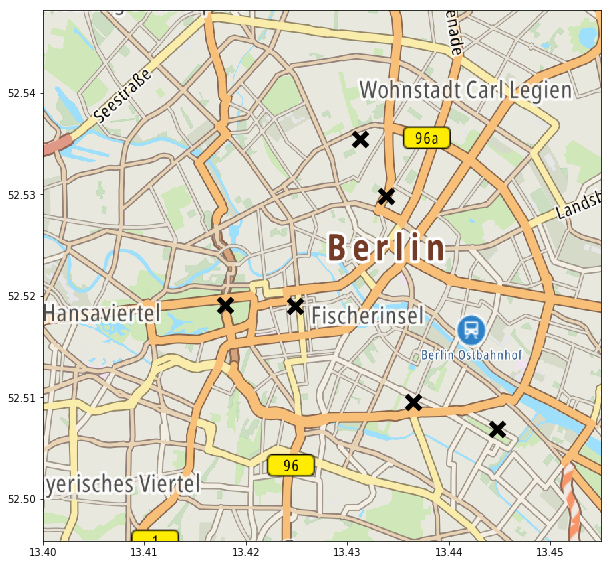

In [55]:
env.render()

In [66]:
env.step(4)

(array([1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.   , 0.   , 0.   ,
        0.   , 1.   , 0.   , 0.   , 0.437, 0.647, 0.332, 0.243, 0.432,
        0.437, 0.   , 0.25 , 0.254, 0.528, 0.302, 0.647, 0.25 , 0.   ,
        0.379, 0.691, 0.405, 0.332, 0.254, 0.379, 0.   , 0.555, 0.251,
        0.243, 0.528, 0.691, 0.555, 0.   , 0.417, 0.432, 0.302, 0.405,
        0.251, 0.417, 0.   ]), -0.917, False, {})

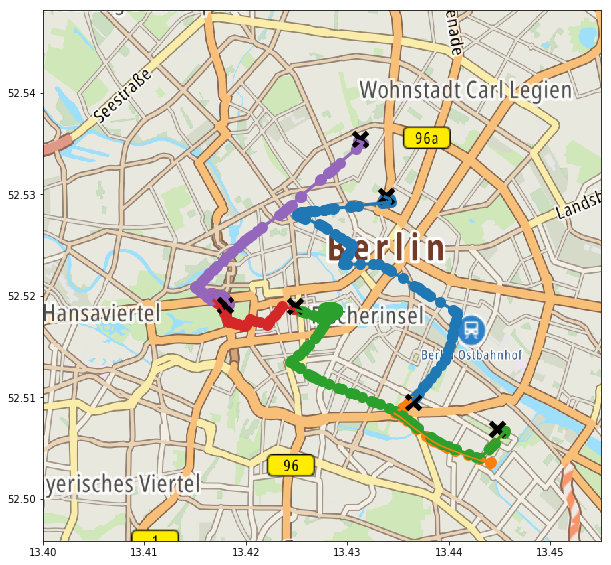

In [67]:
env.render()

# Training of Reinforcement Learning Algorithm

In [ ]:
ray.init()

config={
    "env": Traveling_Env,
    "env_config": {"number_destinations": number_destinations,
                   "env_settings": env_settings,
                   "movie": False},
    "model": {"fcnet_hiddens": [50,50,20],}
}

tune.run(
    "PPO",
    checkpoint_freq=10,
    config=config
)

2019-12-12 09:52:53,208	WARNING worker.py:1268 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-12-12 09:52:53,215	INFO resource_spec.py:205 -- Starting Ray with 1.56 GiB memory available for workers and up to 0.79 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.56 GiB heap, 0.0/0.54 GiB objects
Memory usage on this node: 5.4/8.0 GiB

(pid=10165) /Users/nicolaskuhaupt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
(pid=10165)   from ._conv import register_converters as _register_converters
(pid=10165) 2019-12-12 09:53:24,947	INFO trainer.py:345 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 3/4 CPUs, 0/0 GPUs, 0.0/1.56 GiB heap, 0.0/0.54 GiB objects
Memory usage on this node: 5.7/8.0 GiB
Result logdir: /Users/nicolaskuhaupt/ray_results/PPO
Number of trials: 1 ({'RUNNING': 1})
RUNNING trials:
 - PPO_Traveling_Env_0:	RUNNING

(pid=10165) 2019-12-12 09:53:27,314	INFO

(pid=10163) /Users/nicolaskuhaupt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
(pid=10163)   from ._conv import register_converters as _register_converters
(pid=10165) 2019-12-12 09:53:42,394	INFO tf_policy.py:358 -- Optimizing variable <tf.Variable 'default_policy/fc_1/kernel:0' shape=(48, 50) dtype=float32>
(pid=10165) 2019-12-12 09:53:42,395	INFO tf_policy.py:358 -- Optimizing variable <tf.Variable 'default_policy/fc_1/bias:0' shape=(50,) dtype=float32>
(pid=10165) 2019-12-12 09:53:42,395	INFO tf_policy.py:358 -- Optimizing variable <tf.Variable 'default_policy/fc_value_1/kernel:0' shape=(48, 50) dtype=float32>
(pid=10165) 2019-12-12 09:53:42,395	INFO tf_policy.py:358 -- Optimizing variable <tf.Variable 'default_policy/fc_value_1/bias:0' shape=(50,) dtype=float32>
(pid=10165) 2019-12-12 09:53:

2019-12-12 09:53:45,720	WARNING util.py:133 -- The `fetch_result` operation took 0.8118500709533691 seconds to complete, which may be a performance bottleneck.


Result for PPO_Traveling_Env_0:
  custom_metrics: {}
  date: 2019-12-12_09-53-44
  done: false
  episode_len_mean: 19.82587064676617
  episode_reward_max: 5.362
  episode_reward_mean: -7.357104477611939
  episode_reward_min: -31.175999999999995
  episodes_this_iter: 201
  episodes_total: 201
  experiment_id: 06a3578f058f4072b1194747870558f4
  hostname: Nicolass-MBP
  info:
    grad_time_ms: 2120.078
    learner:
      default_policy:
        cur_kl_coeff: 0.20000000298023224
        cur_lr: 4.999999873689376e-05
        entropy: 1.7840924263000488
        entropy_coeff: 0.0
        kl: 0.007313591428101063
        policy_loss: -0.007476398721337318
        total_loss: 44.26872634887695
        vf_explained_var: 0.09686081856489182
        vf_loss: 44.274742126464844
    load_time_ms: 92.915
    num_steps_sampled: 4000
    num_steps_trained: 3968
    sample_time_ms: 3726.493
    update_time_ms: 1853.642
  iterations_since_restore: 1
  node_ip: 192.168.43.199
  num_healthy_workers: 2
  o

2019-12-12 09:53:59,128	WARNING util.py:133 -- The `process_trial` operation took 14.22029423713684 seconds to complete, which may be a performance bottleneck.


# Evaluation of Algorithm

In [88]:
ray.shutdown()

In [68]:
with open(f'env_eval_settings_{number_destinations}_spots.pkl', 'rb') as f:
    env_eval_settings = pickle.load(f)

2019-12-12 09:35:08,102	WARNING worker.py:1268 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-12-12 09:35:08,107	INFO resource_spec.py:205 -- Starting Ray with 1.56 GiB memory available for workers and up to 0.8 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2019-12-12 09:35:08,504	INFO trainer.py:345 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2019-12-12 09:35:12,412	INFO rollout_worker.py:768 -- Built policy map: {'default_policy': <ray.rllib.policy.tf_policy_template.PPOTFPolicy object at 0x1c43590b70>}
2019-12-12 09:35:12,413	INFO rollout_worker.py:769 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x1c43573780>}
2019-12-12 09:35:12,414	INFO rollout_worker.py:370 -- Built filter map: {'default_p

(pid=10058) /Users/nicolaskuhaupt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
(pid=10058)   from ._conv import register_converters as _register_converters
(pid=10060) /Users/nicolaskuhaupt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
(pid=10060)   from ._conv import register_converters as _register_converters


2019-12-12 09:35:17,141	WARNING actor.py:583 -- Actor is garbage collected in the wrong driver. Actor id = ActorID(7c3ddc2001000000), class name = RolloutWorker.
2019-12-12 09:35:17,142	WARNING actor.py:583 -- Actor is garbage collected in the wrong driver. Actor id = ActorID(7d58f41501000000), class name = RolloutWorker.
2019-12-12 09:35:17,300	INFO trainable.py:358 -- Restored from checkpoint: /Users/nicolaskuhaupt/ray_results/PPO/PPO_Traveling_Env_0_2019-12-12_08-10-075tsyz1jh/checkpoint_110/checkpoint-110
2019-12-12 09:35:17,301	INFO trainable.py:365 -- Current state after restoring: {'_iteration': 110, '_timesteps_total': 440000, '_time_total': 496.6002469062805, '_episodes_total': 58483}


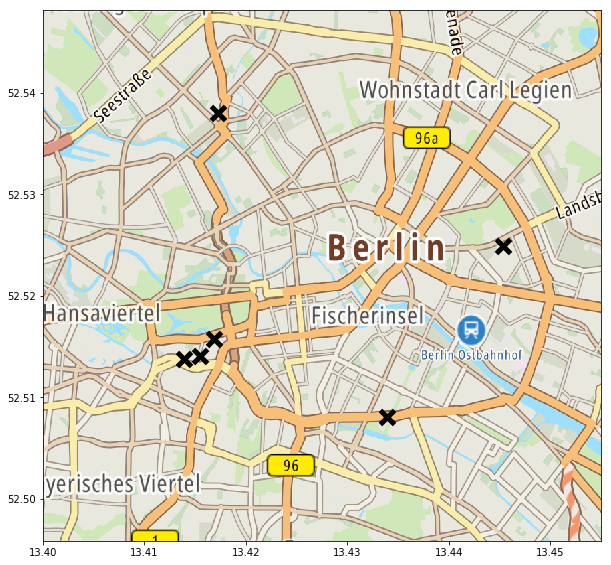

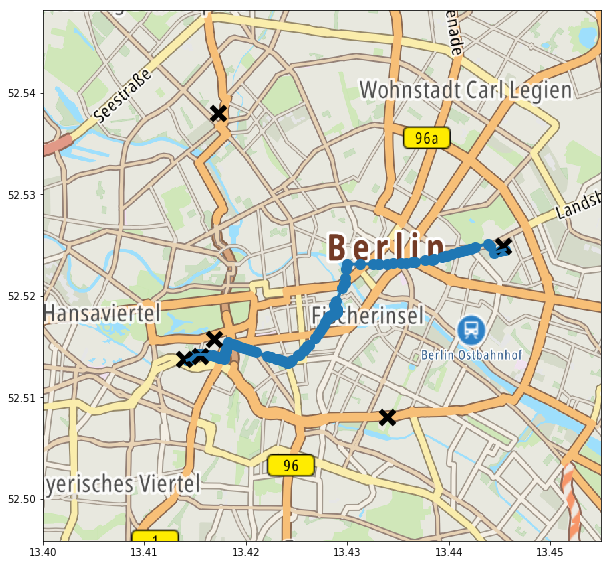

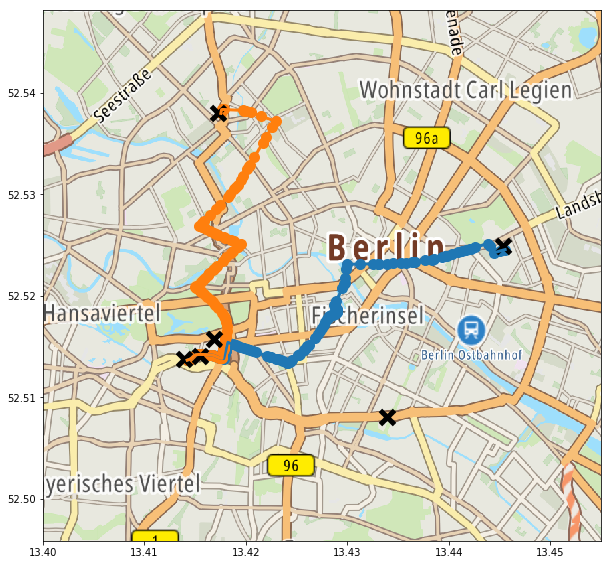

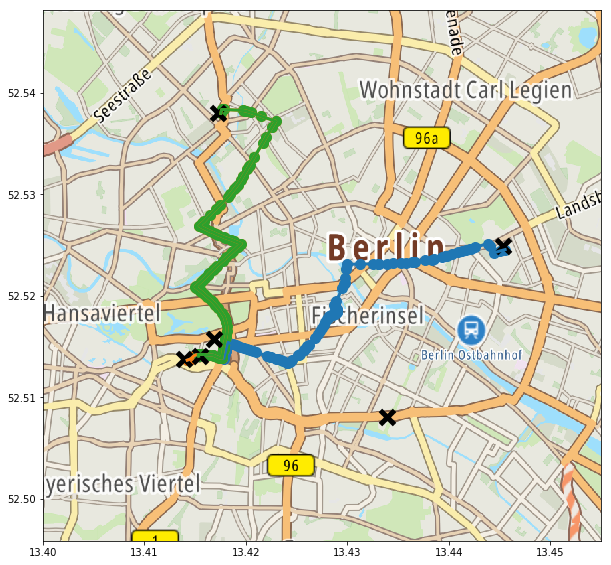

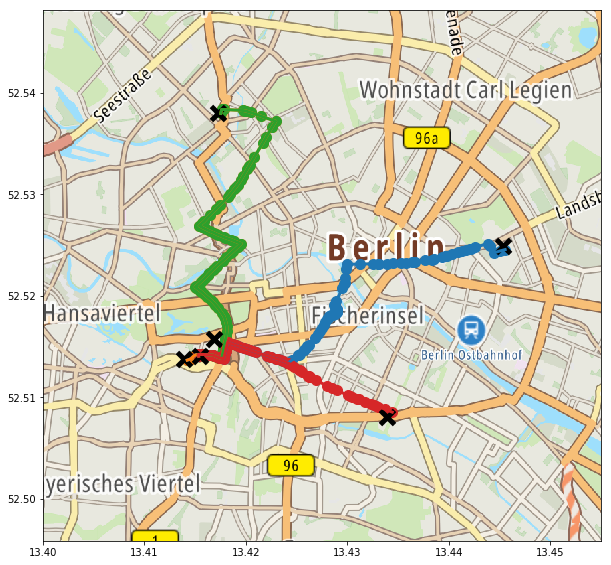

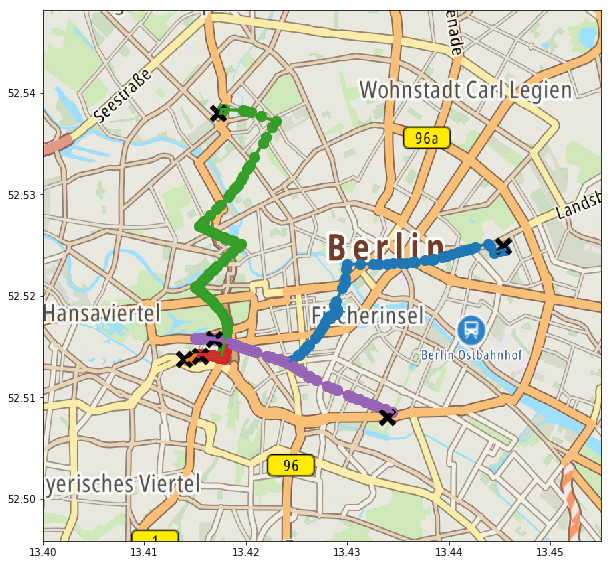

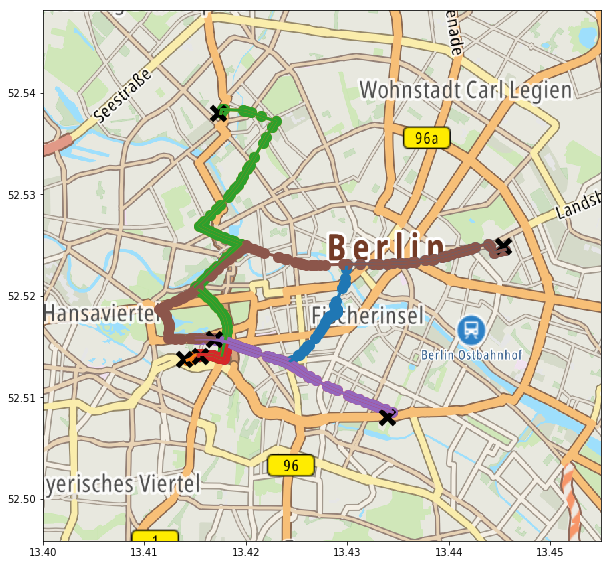

In [89]:
ray.init()

config={
    "env": Traveling_Env,
    "env_config": {"number_destinations": number_destinations,
                   "env_settings": env_eval_settings,
                   "movie": True},
    "model": { "fcnet_hiddens": [50,50,20],}
}

# load checkpoint from training under ray_results
checkpoint_path = "..."

trainer = ppo.PPOTrainer(config=config, env=Traveling_Env)

trainer.restore(checkpoint_path)

env = Traveling_Env(config["env_config"])

obs = env.reset()

env.render()

done = False

while not done:
    action = trainer.compute_action(obs)
    obs, reward, done, info = env.step(action)
    env.render()
    time.sleep(2)

# Create Movie from Evaluation

In [90]:
subprocess.call([
    'ffmpeg', '-framerate', '1', '-i', 'file%02d.png', '-r', '30', '-pix_fmt', 'yuv420p',
    'traveling_salesman.mp4'
])

0